# Torque magnetometry 

In this tutorial, the Ubermag micromagnetic simulation software is used to create 3-dimensional magnetic structure, on which torque magnetometry can be performed. Torque magnetometry is a technique where an external magnetic field is applied in a direction relative to a magnetic sample, an the torque produced measured. This technique can be used to obtain information on the characteristics of the magnetism in the sample like anisotropy.

Torque arises from the cross product of the magnetic moment ${\bf m}$, and the magnetic flux density ${\bf B}$ \[1-2\],
\begin{equation}
{\bf \tau} = {\bf m} \times {\bf B}.
\end{equation}
This equation can be rewritten to account for the torque due to an applied magnetic field
\begin{equation}
{\bf \tau} = \mu_0 {\bf m} \times {\bf H}_{\rm app},
\end{equation}
where ${\bf H}_{app}$ is the applied magnetic field.


The magnetic moment can be obtain from the magnetisation using
\begin{align}
{\bf m} &= \int {\bf M} dV,\\
{\bf m} &=  {\bf M} V,
\end{align}
where ${\bf M}$ is magnetisation, ${\bf m}$ is the magnetic moment, and $V$ is the volume.

## Magnetometry Reference frame
In `mag2exp` the experimental reference for magnetometry is defined to be congruent as the sample reference frame.

## The micromagnetic simulation
A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-dimensional magnetic structure.

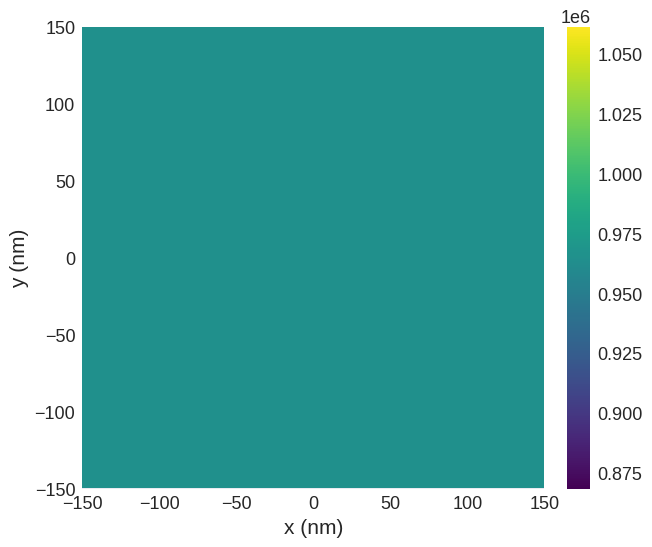

In [1]:
import discretisedfield as df
import matplotlib.pyplot as plt
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

Ms = 9.65e5
H_mag = 2.38e6

system = mm.System(name="Box2")

system.energy = (
    mm.Exchange(A=8.78e-13)
    + mm.UniaxialAnisotropy(K=1.18e6, u=(0, 0, 1))
    + mm.Demag()
    + mm.Zeeman(H=(0, 0, 0))
)

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=(0, 0, 1), norm=Ms)
system.m.z.sel("z").mpl.scalar()

Relax the system and plot its magnetisation.

Running OOMMF (ExeOOMMFRunner)[2025-06-01T15:36:56]... (0.5 s)


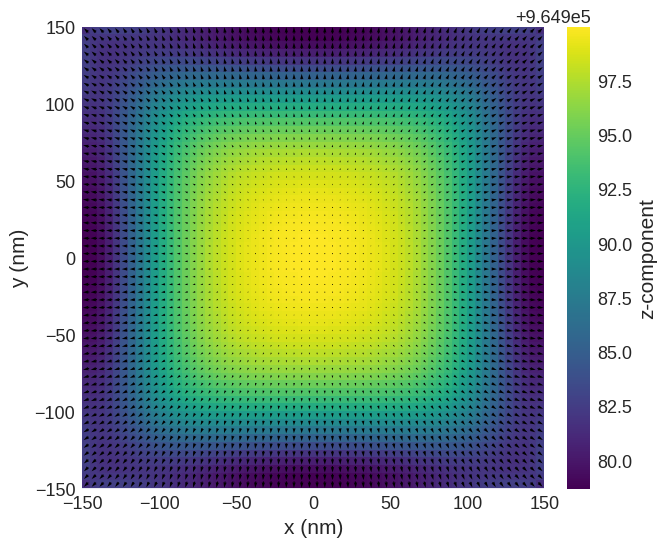

In [2]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

## Computing Torque Magnetometry
The torque can be calculated using the `mag2exp.magnetometry` module.

In [3]:
import mag2exp

mag2exp.magnetometry.torque(system.m, system.energy.zeeman.H)

array([0., 0., 0.])

## Recreating experiments
A common experiment with torque magnetometry is to rotate the magnetic field relative to the sample and measure the torque. Doing this at high applied magnetic fields can reveal the magnetic anisotropy of the sample.

Here we rotate the applied magnetic field a full $2\pi$ perpendicular to the $x$ axis, with our initial field in the $z$ direction. The sample has uniaxial anisotropy in the $z$ direction, hence the torque forms a periodic pattern.

In [4]:
angles = np.linspace(0, 2 * np.pi, 71)

torque_val_x = np.full_like(angles, np.nan)
torque_val_y = np.full_like(angles, np.nan)
torque_val_z = np.full_like(angles, np.nan)
for i, angle in enumerate(angles):
    system.energy.zeeman.H = (0, H_mag * np.sin(angle), H_mag * np.cos(angle))
    md.drive(system, verbose=0)
    torque_val_x[i], torque_val_y[i], torque_val_z[i] = mag2exp.magnetometry.torque(
        system.m, system.energy.zeeman.H
    )

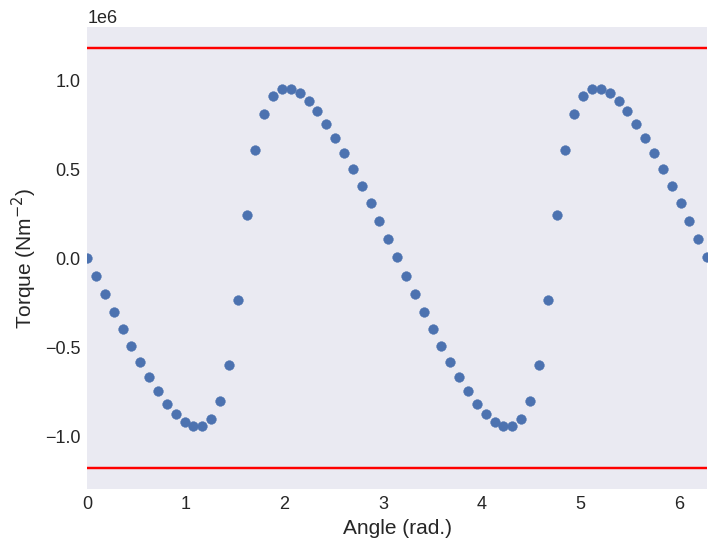

In [5]:
fig, ax = plt.subplots(dpi=100)
ax.hlines(
    system.energy.uniaxialanisotropy.K,
    xmin=np.min(angles),
    xmax=np.max(angles),
    color="r",
)
ax.hlines(
    -system.energy.uniaxialanisotropy.K,
    xmin=np.min(angles),
    xmax=np.max(angles),
    color="r",
)
ax.scatter(angles, torque_val_x)
ax.set_xlabel("Angle (rad.)")
ax.set_ylabel(r"Torque (Nm$^{-2}$)")
ax.set_xlim([0, 2 * np.pi])
plt.show()

## References
\[1\] Jackson, J. D. Classical electrodynamics. (1999).

\[2\] Dunsmore, M. G., et al. Three-axis torque investigation of interfacial exchange coupling in a NiFe/CoO bilayer micromagnetic disk. AIP Advances 12.3 (2022).